Alunos: Gustavo Guerreiro e João Martinho

# TRABALHO PARCIAL 02 – Segmentação de objetos

A partir das imagens existentes no dataset disponibilizado, faça a segmentação dos núcleos das células. Utilize apenas técnicas de segmentação e pré-processamento.

## A pipeline

### Preparação do ambiente

Inicialmente, importamos as bibliotecas necessárias, nomeadamente o OpenCV, o NumPy, o Matplotlib e o Pandas, responsáveis, respectivamente, pelas operações de visão computacional, manipulação numérica, visualização gráfica e organização dos dados em tabelas.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Isolamento de células

A função `isolar_celula` converte a imagem para escala de cinza e aplica um threshold binário para separar a célula do seu fundo escuro, substituindo-o por branco a mantendo apenas a região da célula, que por sua vez é retornada ao espaço de cores RGB.

In [2]:
def isolar_celula(imagem):
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    _, mascara = cv2.threshold(imagem_cinza, 10, 255, cv2.THRESH_BINARY)
    fundo_branco = np.full(imagem.shape, 255, dtype=np.uint8)
    imagem_isolada = np.where(mascara[:, :, None] == 255, imagem, fundo_branco)
    return imagem_isolada

### Pré-processamento da Imagem
A função `pre_processar_imagem` converte a imagem para o espaço de cores HSV e isola o canal de Saturação (S). O canal é particularmente eficaz para diferenciar os núcleos, que são os elementos mais saturados nas imagens. Em seguida, aplica-se a técnica CLAHE para realçar o contraste local, o que facilita a separação entre o núcleo e o citoplasma na etapa seguinte.

In [3]:
def pre_processar_imagem(imagem):
    hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)
    _, S, _ = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    canal_saturacao_melhorado = clahe.apply(S)
    return canal_saturacao_melhorado

### Criação da Máscara do Núcleo
A função `criar_mascara_nucleo` recebe o canal de saturação pré-processado e aplica um limiar (threshold) fixo. Isso gera uma máscara binária (preto e branco), onde os pixels brancos representam as áreas com alta saturação, correspondendo à localização provável do núcleo.

In [4]:
def criar_mascara_nucleo(canal_saturacao, limiar):
    _, mascara_nucleo = cv2.threshold(canal_saturacao, limiar, 255, cv2.THRESH_BINARY)
    return mascara_nucleo

### Preparação dos Marcadores para o Watershed
A função `preparar_marcadores_watershed` cria três regiões distintas: o "primeiro plano certo" (centro dos núcleos), obtido por erosão; o "fundo certo", obtido por dilatação; e a "região desconhecida" entre eles. O algoritmo Watershed usará essas marcações para traçar as fronteiras exatas dos núcleos.

In [5]:
def preparar_marcadores_watershed(mascara_nucleo, kernel):
    primeiro_plano_certo = cv2.erode(mascara_nucleo, kernel, iterations=3)
    fundo_certo = cv2.dilate(mascara_nucleo, kernel, iterations=4)
    regiao_desconhecida = cv2.subtract(fundo_certo, primeiro_plano_certo)
    _, marcadores = cv2.connectedComponents(primeiro_plano_certo)
    marcadores = marcadores + 1
    marcadores[regiao_desconhecida == 255] = 0
    return marcadores

### Geração da Máscara com Watershed
A função `gerar_mascara_com_watershed` aplica o algoritmo Watershed propriamente dito. Utilizando os marcadores da etapa anterior, ele segmenta a imagem, tratando as diferentes intensidades de pixel como um relevo topográfico. O resultado é uma máscara onde cada núcleo (ou lóbulo) é identificado como uma região única.

In [6]:
def gerar_mascara_com_watershed(imagem, marcadores):
    marcadores_finais = cv2.watershed(imagem, marcadores)
    mascara_final = np.zeros_like(imagem[:,:,0], dtype=np.uint8)
    mascara_final[marcadores_finais > 1] = 255
    return mascara_final

### Limpeza da Máscara Final
A função `limpar_mascara_final` realiza um pós-processamento na máscara gerada pelo Watershed. Ela aplica operações morfológicas de abertura e fechamento para suavizar as bordas, remover pequenos ruídos no cito e preencher possíveis buracos nos núcleos segmentados e no citoplasma.

In [7]:
def limpar_mascara_final(mascara, kernel):
    mascara_limpa = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel, iterations=2)
    mascara_limpa = cv2.morphologyEx(mascara_limpa, cv2.MORPH_CLOSE, kernel, iterations=1)
    return mascara_limpa

### Desenho dos Contornos
A função `desenhar_contornos_na_imagem` identifica os contornos na máscara final já limpa e os desenha sobre uma cópia da imagem original. Isso permite a visualização clara das regiões que o algoritmo segmentou.

In [8]:
def desenhar_contornos_na_imagem(imagem, mascara_limpa):
    contornos, _ = cv2.findContours(mascara_limpa, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    imagem_com_contornos = imagem.copy()
    cv2.drawContours(imagem_com_contornos, contornos, -1, (0, 0, 255), 1)
    return imagem_com_contornos

### Exibição da Imagem Final
A função `exibir_imagem_final` é um utilitário para a visualização, ele usa matplotlib para mostrar a imagem recebida.

In [9]:
def exibir_imagem_final(imagem):
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    plt.imshow(imagem_rgb)
    plt.axis('off')
    plt.show()

### Contagem de Lóbulos
A função `contar_lobulos` é responsável pela quantificação. Ela recebe a máscara final, aplica uma leve erosão para garantir que lóbulos que se tocam por poucos pixels sejam separados, e então conta o número de contornos externos resultantes, que corresponde ao número de lóbulos.

In [10]:
def contar_lobulos(mascara_limpa):
    mascara_limpa = cv2.erode(mascara_limpa, np.ones((3,3)), iterations=1)
    contornos, _ = cv2.findContours(mascara_limpa, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contornos)

### Orquestração da Segmentação
A função `segmentar_nucleo_celular` é o método principal que contém todo o fluxo de trabalho. Ela chama cada uma das funções auxiliares na sequência correta, desde o carregamento da imagem até a contagem final dos lóbulos, retornando a quantidade encontrada e, opcionalmente, exibindo a imagem com os contornos.

In [11]:
def segmentar_nucleo_celular(caminho_imagem, mostrar=True):
    imagem_original = cv2.imread(caminho_imagem)
    imagem_processada = isolar_celula(imagem_original)
    canal_saturacao_melhorado = pre_processar_imagem(imagem_processada)
    mascara_nucleo = criar_mascara_nucleo(canal_saturacao_melhorado, 126)
    kernel = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]], dtype=np.uint8)
    marcadores = preparar_marcadores_watershed(mascara_nucleo, kernel)
    mascara_watershed = gerar_mascara_com_watershed(imagem_processada, marcadores)
    mascara_final_limpa = limpar_mascara_final(mascara_watershed, kernel)
    num_lobulos = contar_lobulos(mascara_final_limpa)
    imagem_com_contornos = desenhar_contornos_na_imagem(imagem_processada, mascara_final_limpa)
    if mostrar:
        exibir_imagem_final(imagem_com_contornos)
    return num_lobulos

## Execução
A seguir se itera sobre as imagens de ambos os datasets segmentando o núcleo e seus lóbulos, além de gerar uma tabela com Pandas contando a quantidade de lóbulos encontrados nos núcleos.

Processando: dataset_linfocitos/linfocito00.png


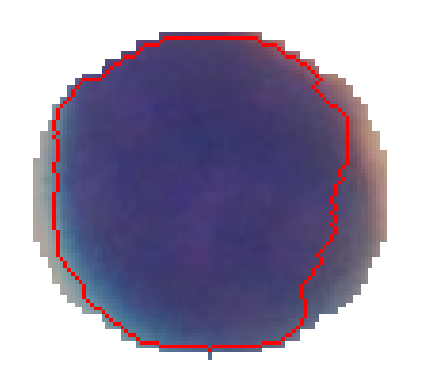

Processando: dataset_linfocitos/linfocito01.png


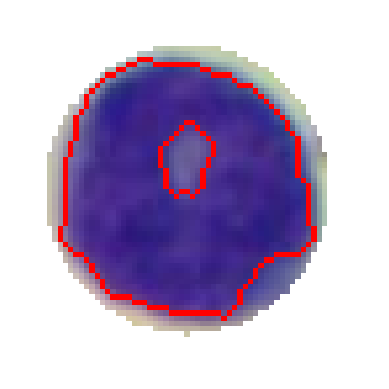

Processando: dataset_linfocitos/linfocito02.png


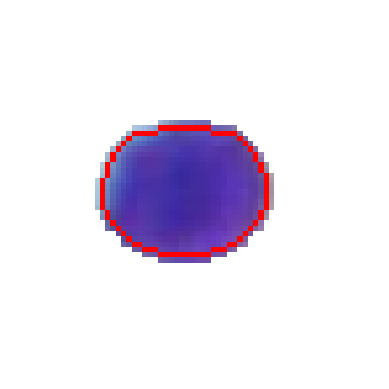

Processando: dataset_neutrofilos/neutrofilo00.png


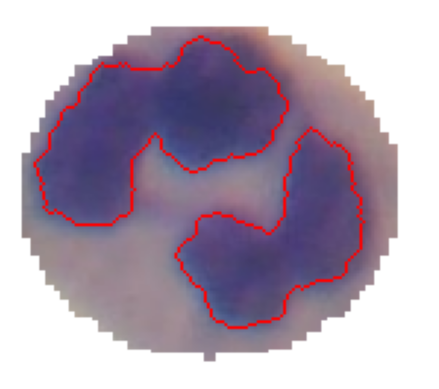

Processando: dataset_neutrofilos/neutrofilo01.png


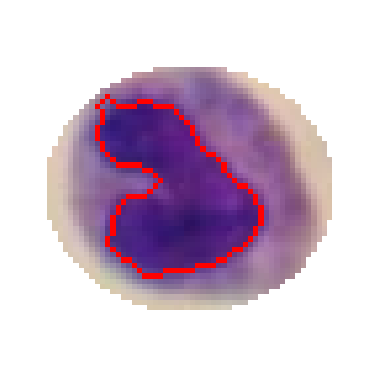

Processando: dataset_neutrofilos/neutrofilo02.png


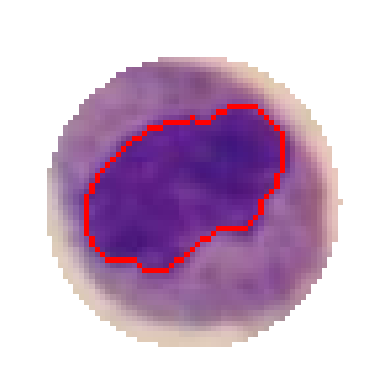

Processando: dataset_neutrofilos/neutrofilo03.png


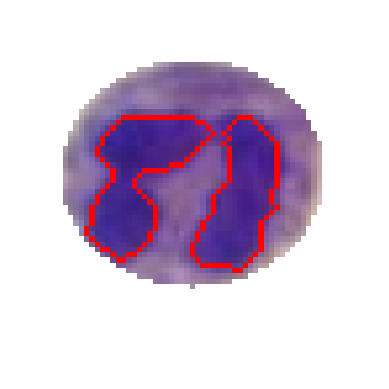

Processando: dataset_neutrofilos/neutrofilo04.png


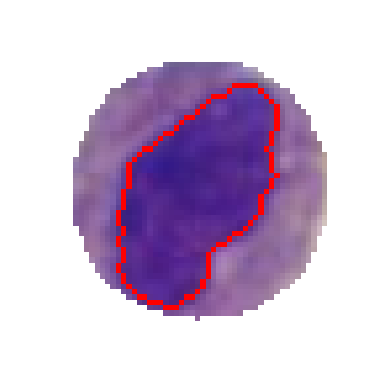

Processando: dataset_neutrofilos/neutrofilo05.png


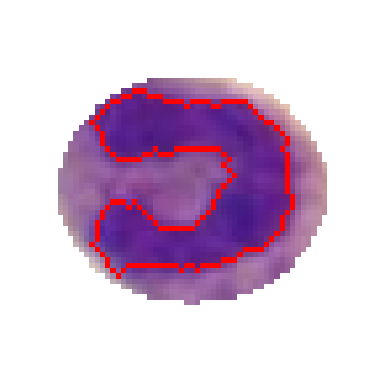

Processando: dataset_neutrofilos/neutrofilo06.png


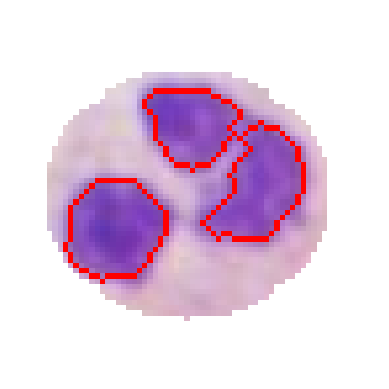

Processando: dataset_neutrofilos/neutrofilo07.png


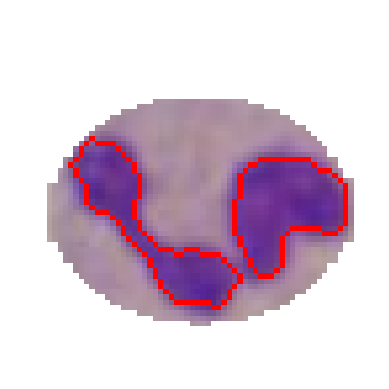

Processando: dataset_neutrofilos/neutrofilo08.png


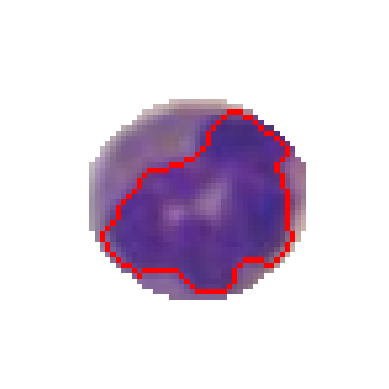

Processando: dataset_neutrofilos/neutrofilo09.png


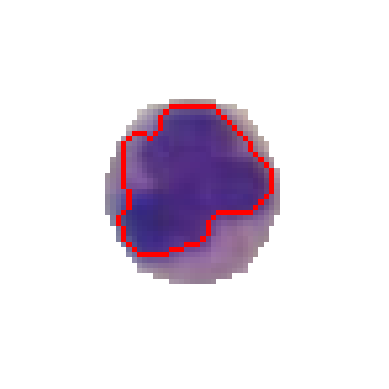

,Arquivo,Lóbulos encontrados
0,dataset_linfocitos/linfocito00.png,1
1,dataset_linfocitos/linfocito01.png,1
2,dataset_linfocitos/linfocito02.png,1
3,dataset_neutrofilos/neutrofilo00.png,2
4,dataset_neutrofilos/neutrofilo01.png,1
5,dataset_neutrofilos/neutrofilo02.png,1
6,dataset_neutrofilos/neutrofilo03.png,2
7,dataset_neutrofilos/neutrofilo04.png,1
8,dataset_neutrofilos/neutrofilo05.png,1
9,dataset_neutrofilos/neutrofilo06.png,3


In [12]:
resultados = []

for i in range(3):
    caminho = f'dataset_linfocitos/linfocito0{i}.png'
    print(f"Processando: {caminho}")
    qtd = segmentar_nucleo_celular(caminho)
    resultados.append({"Arquivo": caminho, "Lóbulos encontrados": qtd})

for i in range(10):
    caminho = f'dataset_neutrofilos/neutrofilo0{i}.png'
    print(f"Processando: {caminho}")
    qtd = segmentar_nucleo_celular(caminho)
    resultados.append({"Arquivo": caminho, "Lóbulos encontrados": qtd})

pd.DataFrame(resultados)